In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wednesday May 10 10:11:42 2023
Example Code for training an Image Deep Artifact Suppression network (FastDVDnet) for interactive MRI
Trained from flower image dataset.

@author: Olivier Jaubert
"""

import os
import numpy as np
import tensorflow as tf
try:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('running on CPU')
import tensorflow_mri as tfmri
import random
import matplotlib.pyplot as plt
import datetime
import pathlib
# Local imports (works if you are in project folder)
import model.layers as layers
import utils.preprocessing_natural_images as preproc_filename_2_kspace
import utils.preprocessing_trajectory_gen as preproc_traj
import utils.preprocessing_fastdvdnet_noselect as preproc_fastdvdnet
import utils.preprocessing_rolling_fastdvdnet as preproc_roll
import utils.display_function_fastdvdnet as display_func

#Set seed for all packages
seed_value=1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


2023-05-31 10:21:59.419746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:21:59.424560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:21:59.424663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-31 10:22:02.176366: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [3]:
#Configuration
learning_rate=0.0001

config_traj=preproc_traj.config_optimized_traj()
config_preproc=preproc_fastdvdnet.config_base_preproc()
config_natural_images={'base_resolution':config_preproc['base_resolution'],'phases':config_preproc['phases'],'num_coils':10,'addmotion':1}

config={'experiment_path': 'Training_folder',
        'experiment_name': 'Test_FastDVDnet',
        'split' : [0.7,0.15,0.15], #train, val, test
        'split_mode': 'noshuffle', #noshuffle or random
        'learning_rate': learning_rate,
        'optimizer': tf.keras.optimizers.Adam(learning_rate=learning_rate,clipnorm=1),
        'epochs':200,
        'loss': tfmri.losses.StructuralSimilarityLoss(rank=2),
        'metrics':[tfmri.metrics.PeakSignalToNoiseRatio(rank=2),
                   tfmri.metrics.StructuralSimilarity(rank=2)]}

imshape=(config_preproc['phases'],config_preproc['base_resolution'],config_preproc['base_resolution'])

config_model={'scales': 3,
      'block_depth': 2,
      'base_filters': 32,
      'kernel_size': 3,
      'use_deconv': 'PixelShuffle',
      'rank': 2,
      'activation': tf.keras.activations.relu,
      'out_channels': 1,
      'kernel_initializer': tf.keras.initializers.HeUniform(seed=1),
      'time_distributed': False}

In [4]:
# Read files and split data 
train_files=[]
val_files=[]
test_files=[]
sorted_files=[x for x in sorted(list(map(str,data_dir.glob('roses/*'))))]
n=len(sorted_files); ntrain=int(config['split'][0]*n); nval=int(config['split'][1]*n); ntest=int(np.ceil(config['split'][2]*n))

train_files=sorted_files[:ntrain]
val_files=sorted_files[ntrain:ntrain+nval]
test_files=sorted_files[ntrain+nval:ntrain+nval+ntest]

# train_files=np.concatenate(train_files,axis=0)
# val_files=np.concatenate(val_files,axis=0)
# test_files=np.concatenate(test_files,axis=0)

# Shuffle files.
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

print('Total/Train/Val/Test:',len(train_files)+len(val_files)+len(test_files),
      '/',len(train_files),'/',len(val_files),'/',len(test_files),'leftovers:',n-ntrain-nval-ntest)

Total/Train/Val/Test: 641 / 448 / 96 / 97 leftovers: 0


dict_keys(['image', 'traj'])


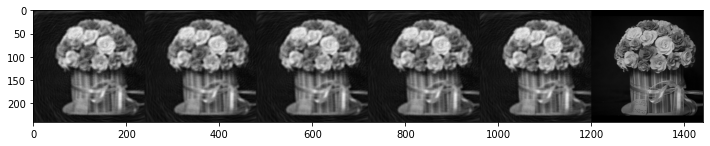

In [5]:
#Define Preprocessing run once to get input shapes
preproc_natural_image=preproc_filename_2_kspace.preprocessing_fn(**config_natural_images)
traj_function=preproc_traj.create_traj_fn(**config_traj)
preproc_function=preproc_fastdvdnet.preprocessing_fn(**config_preproc)
roll_function=preproc_roll.preprocessing_fn()
# Run Preprocessing once on case [0]
kspace=preproc_natural_image(train_files[1])
ds=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds)
for element in image:
  print(element.keys())
  inputs_temp,gt_temp=preproc_function(element)
  inputs,gt=roll_function(inputs_temp,gt_temp)
plt.figure(figsize=(12,3))
plt.imshow(np.abs(np.concatenate((inputs[:,:,0],inputs[:,:,1],inputs[:,:,2],inputs[:,:,3],inputs[:,:,4],gt[:,:,0]),axis=1)),cmap='gray')

In [13]:
#Creating Tensorflow dataset
# Create datasets.
datasets=[train_files,val_files,test_files]
dataset_withtransforms=[]
for pp,dataset in enumerate(datasets):
    dataset = tf.data.Dataset.from_tensor_slices(
        tf.convert_to_tensor(list(map(str, dataset)), dtype=tf.string))
    #dataset =tf.data.Dataset.from_tensor_slices(list(map(str, dataset))).filter(lambda x: tf.strings.regex_full_match(x,'.*png'))
    dataset=dataset.map(preproc_natural_image,num_parallel_calls=1)
    dataset = dataset.apply(traj_function)
    dataset=dataset.map(preproc_function,num_parallel_calls=1)
    if pp==0:
        dataset=dataset.cache()
    dataset=dataset.map(roll_function,num_parallel_calls=1)
    dataset=dataset.shuffle(buffer_size=8,seed=1)
    if pp>0:
        dataset=dataset.cache()
    dataset=dataset.batch(1,drop_remainder=True)
    dataset=dataset.prefetch(buffer_size=-1)
    dataset_withtransforms.append(dataset)

In [18]:
#Defining Paths
path = config['experiment_path']
exp_name = os.path.splitext(os.path.basename(config['experiment_name']))[0]
exp_name += '_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
exp_dir = os.path.join(path, exp_name)

#Define and compile Model
image_inputs= tf.keras.Input(inputs.shape)
outputs=layers.FastDVDNet(**config_model)(image_inputs)
model=tf.keras.Model(inputs=image_inputs,outputs=outputs)

model.compile(optimizer=config['optimizer'],
                    loss=config['loss'],
                    metrics=config['metrics'] or None,
                    run_eagerly=False)

model.summary()
callbacks=[]
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
callbacks.append(tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_weights_only=False,
        save_best_only=True))
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=os.path.join(exp_dir,'logs')))
display_fn=display_func.display_fn(complex_part='abs',selected_image=-1)
callbacks.append(tfmri.callbacks.TensorBoardImages(log_dir=os.path.join(exp_dir,'logs'),
     max_images=2,x= dataset_withtransforms[1],display_fn=display_fn))


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 5)]     0         
                                                                 
 fast_dvd_net_2 (FastDVDNet)  (None, 240, 240, 1)      1589506   
                                                                 
Total params: 1,589,506
Trainable params: 1,589,506
Non-trainable params: 0
_________________________________________________________________


In [19]:
history=model.fit(dataset_withtransforms[0],
          epochs=config['epochs'],
          verbose=1,
          callbacks=callbacks,
          validation_data=dataset_withtransforms[1])

Epoch 1/200
  5/448 [..............................] - ETA: 20s - loss: 0.9991 - psnr: 16.7040 - ssim: 0.7131 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0241s vs `on_train_batch_end` time: 0.0301s). Check your callbacks.


447/448 [============================>.] - ETA: 0s - loss: 0.6347 - psnr: 0.5398 - ssim: 0.4334WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 56ms/step - loss: 0.6346 - psnr: 0.5332 - ssim: 0.4333 - val_loss: 0.5637 - val_psnr: -3.4157 - val_ssim: 0.4363
Epoch 2/200
447/448 [============================>.] - ETA: 0s - loss: 0.4264 - psnr: 6.3768 - ssim: 0.5736WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 25s 57ms/step - loss: 0.4256 - psnr: 6.4246 - ssim: 0.5744 - val_loss: 0.2221 - val_psnr: 22.6373 - val_ssim: 0.7779
Epoch 3/200
448/448 [==============================] - ETA: 0s - loss: 0.2179 - psnr: 21.6103 - ssim: 0.7821WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 26s 58ms/step - loss: 0.2179 - psnr: 21.6103 - ssim: 0.7821 - val_loss: 0.1896 - val_psnr: 22.1968 - val_ssim: 0.8104
Epoch 4/200
448/448 [==============================] - ETA: 0s - loss: 0.1932 - psnr: 22.5668 - ssim: 0.8068WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 26s 59ms/step - loss: 0.1932 - psnr: 22.5668 - ssim: 0.8068 - val_loss: 0.1787 - val_psnr: 20.3042 - val_ssim: 0.8213
Epoch 5/200
448/448 [==============================] - ETA: 0s - loss: 0.1875 - psnr: 22.6117 - ssim: 0.8125WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 26s 58ms/step - loss: 0.1875 - psnr: 22.6117 - ssim: 0.8125 - val_loss: 0.1683 - val_psnr: 22.6896 - val_ssim: 0.8317
Epoch 6/200
448/448 [==============================] - ETA: 0s - loss: 0.1754 - psnr: 22.8939 - ssim: 0.8246WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 26s 59ms/step - loss: 0.1754 - psnr: 22.8939 - ssim: 0.8246 - val_loss: 0.1603 - val_psnr: 24.5013 - val_ssim: 0.8397
Epoch 7/200
448/448 [==============================] - 24s 54ms/step - loss: 0.1686 - psnr: 23.3588 - ssim: 0.8314 - val_loss: 0.1627 - val_psnr: 22.7751 - val_ssim: 0.8373
Epoch 8/200
447/448 [============================>.] - ETA: 0s - loss: 0.1716 - psnr: 23.0911 - ssim: 0.8284WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 60ms/step - loss: 0.1714 - psnr: 23.1030 - ssim: 0.8286 - val_loss: 0.1530 - val_psnr: 25.2860 - val_ssim: 0.8470
Epoch 9/200
448/448 [==============================] - ETA: 0s - loss: 0.1646 - psnr: 23.7447 - ssim: 0.8354WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 28s 62ms/step - loss: 0.1646 - psnr: 23.7447 - ssim: 0.8354 - val_loss: 0.1501 - val_psnr: 23.7918 - val_ssim: 0.8499
Epoch 10/200
448/448 [==============================] - ETA: 0s - loss: 0.1622 - psnr: 23.9029 - ssim: 0.8378WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 60ms/step - loss: 0.1622 - psnr: 23.9029 - ssim: 0.8378 - val_loss: 0.1464 - val_psnr: 24.8103 - val_ssim: 0.8536
Epoch 11/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1565 - psnr: 24.2451 - ssim: 0.8435 - val_loss: 0.1510 - val_psnr: 22.1911 - val_ssim: 0.8490
Epoch 12/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1560 - psnr: 24.2068 - ssim: 0.8440 - val_loss: 0.1504 - val_psnr: 23.4404 - val_ssim: 0.8496
Epoch 13/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1547 - psnr: 24.4535 - ssim: 0.8453 - val_loss: 0.1486 - val_psnr: 25.8007 - val_ssim: 0.8514
Epoch 14/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1540 - psnr: 24.6697 - ssim: 0.8460 - val_loss: 0.1489 - val_psnr: 21.4671 - val_ssim: 0.8511
Epoch 15/200
448/448 [==============================] - ETA: 0s - loss: 0.1507 - psnr: 24.2271 - ssim: 0.8493WARNING:tensorflow:Skipping full s

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.1507 - psnr: 24.2271 - ssim: 0.8493 - val_loss: 0.1433 - val_psnr: 23.9885 - val_ssim: 0.8567
Epoch 16/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1449 - psnr: 25.0078 - ssim: 0.8551 - val_loss: 0.1437 - val_psnr: 22.3043 - val_ssim: 0.8563
Epoch 17/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1444 - psnr: 25.0984 - ssim: 0.8556 - val_loss: 0.1471 - val_psnr: 19.9098 - val_ssim: 0.8529
Epoch 18/200
448/448 [==============================] - ETA: 0s - loss: 0.1387 - psnr: 25.5492 - ssim: 0.8613WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.1387 - psnr: 25.5492 - ssim: 0.8613 - val_loss: 0.1337 - val_psnr: 26.6664 - val_ssim: 0.8663
Epoch 19/200
447/448 [============================>.] - ETA: 0s - loss: 0.1399 - psnr: 24.9715 - ssim: 0.8601WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 60ms/step - loss: 0.1403 - psnr: 24.9584 - ssim: 0.8597 - val_loss: 0.1313 - val_psnr: 26.8416 - val_ssim: 0.8687
Epoch 20/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1438 - psnr: 24.9891 - ssim: 0.8562 - val_loss: 0.1372 - val_psnr: 27.0098 - val_ssim: 0.8628
Epoch 21/200
448/448 [==============================] - ETA: 0s - loss: 0.1371 - psnr: 25.4163 - ssim: 0.8629WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.1371 - psnr: 25.4163 - ssim: 0.8629 - val_loss: 0.1305 - val_psnr: 26.4418 - val_ssim: 0.8695
Epoch 22/200
448/448 [==============================] - ETA: 0s - loss: 0.1353 - psnr: 25.9758 - ssim: 0.8647WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 60ms/step - loss: 0.1353 - psnr: 25.9758 - ssim: 0.8647 - val_loss: 0.1303 - val_psnr: 26.4039 - val_ssim: 0.8697
Epoch 23/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1353 - psnr: 25.9632 - ssim: 0.8647 - val_loss: 0.1312 - val_psnr: 24.9954 - val_ssim: 0.8688
Epoch 24/200
447/448 [============================>.] - ETA: 0s - loss: 0.1334 - psnr: 25.8786 - ssim: 0.8666WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.1334 - psnr: 25.8956 - ssim: 0.8666 - val_loss: 0.1262 - val_psnr: 27.8227 - val_ssim: 0.8738
Epoch 25/200
447/448 [============================>.] - ETA: 0s - loss: 0.1327 - psnr: 26.1237 - ssim: 0.8673WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 60ms/step - loss: 0.1326 - psnr: 26.1315 - ssim: 0.8674 - val_loss: 0.1257 - val_psnr: 27.5724 - val_ssim: 0.8743
Epoch 26/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1281 - psnr: 25.7914 - ssim: 0.8719 - val_loss: 0.1260 - val_psnr: 26.2328 - val_ssim: 0.8740
Epoch 27/200
447/448 [============================>.] - ETA: 0s - loss: 0.1295 - psnr: 25.6785 - ssim: 0.8705WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.1296 - psnr: 25.6709 - ssim: 0.8704 - val_loss: 0.1228 - val_psnr: 27.9533 - val_ssim: 0.8772
Epoch 28/200
448/448 [==============================] - ETA: 0s - loss: 0.1257 - psnr: 26.5031 - ssim: 0.8743WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.1257 - psnr: 26.5031 - ssim: 0.8743 - val_loss: 0.1192 - val_psnr: 26.5202 - val_ssim: 0.8808
Epoch 29/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1260 - psnr: 26.0444 - ssim: 0.8740 - val_loss: 0.1214 - val_psnr: 25.8590 - val_ssim: 0.8786
Epoch 30/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1225 - psnr: 26.1426 - ssim: 0.8775 - val_loss: 0.1212 - val_psnr: 27.9185 - val_ssim: 0.8788
Epoch 31/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1187 - psnr: 26.3117 - ssim: 0.8813 - val_loss: 0.1215 - val_psnr: 23.5931 - val_ssim: 0.8785
Epoch 32/200
448/448 [==============================] - ETA: 0s - loss: 0.1198 - psnr: 26.5820 - ssim: 0.8802WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 60ms/step - loss: 0.1198 - psnr: 26.5820 - ssim: 0.8802 - val_loss: 0.1173 - val_psnr: 27.2036 - val_ssim: 0.8827
Epoch 33/200
447/448 [============================>.] - ETA: 0s - loss: 0.1179 - psnr: 26.3846 - ssim: 0.8821WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.1178 - psnr: 26.3953 - ssim: 0.8822 - val_loss: 0.1164 - val_psnr: 28.0932 - val_ssim: 0.8836
Epoch 34/200
447/448 [============================>.] - ETA: 0s - loss: 0.1174 - psnr: 26.5004 - ssim: 0.8826WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 60ms/step - loss: 0.1172 - psnr: 26.5186 - ssim: 0.8828 - val_loss: 0.1118 - val_psnr: 27.9502 - val_ssim: 0.8882
Epoch 35/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1177 - psnr: 26.7597 - ssim: 0.8823 - val_loss: 0.1147 - val_psnr: 27.9796 - val_ssim: 0.8853
Epoch 36/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1149 - psnr: 27.1874 - ssim: 0.8851 - val_loss: 0.1118 - val_psnr: 28.1319 - val_ssim: 0.8882
Epoch 37/200
447/448 [============================>.] - ETA: 0s - loss: 0.1146 - psnr: 26.9651 - ssim: 0.8854WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.1146 - psnr: 26.9613 - ssim: 0.8854 - val_loss: 0.1073 - val_psnr: 27.6049 - val_ssim: 0.8927
Epoch 38/200
448/448 [==============================] - 25s 56ms/step - loss: 0.1095 - psnr: 26.6312 - ssim: 0.8905 - val_loss: 0.1093 - val_psnr: 26.3152 - val_ssim: 0.8907
Epoch 39/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1120 - psnr: 26.6907 - ssim: 0.8880 - val_loss: 0.1088 - val_psnr: 26.1613 - val_ssim: 0.8912
Epoch 40/200
447/448 [============================>.] - ETA: 0s - loss: 0.1085 - psnr: 26.8934 - ssim: 0.8915WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 60ms/step - loss: 0.1086 - psnr: 26.8918 - ssim: 0.8914 - val_loss: 0.1061 - val_psnr: 27.7584 - val_ssim: 0.8939
Epoch 41/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1050 - psnr: 27.5766 - ssim: 0.8950 - val_loss: 0.1064 - val_psnr: 25.6920 - val_ssim: 0.8936
Epoch 42/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1082 - psnr: 27.0734 - ssim: 0.8918 - val_loss: 0.1085 - val_psnr: 26.3630 - val_ssim: 0.8915
Epoch 43/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1059 - psnr: 27.5027 - ssim: 0.8941 - val_loss: 0.1092 - val_psnr: 23.1172 - val_ssim: 0.8908
Epoch 44/200
448/448 [==============================] - 25s 55ms/step - loss: 0.1080 - psnr: 26.6169 - ssim: 0.8920 - val_loss: 0.1066 - val_psnr: 27.5213 - val_ssim: 0.8934
Epoch 45/200
447/448 [============================>.] - ETA: 0s - loss: 0.1062 - psnr: 27.1473 - ssim: 0.8938WARNING:tensorflow:Skipping full s

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 28s 62ms/step - loss: 0.1061 - psnr: 27.1537 - ssim: 0.8939 - val_loss: 0.1034 - val_psnr: 27.7889 - val_ssim: 0.8966
Epoch 46/200
448/448 [==============================] - 25s 56ms/step - loss: 0.1032 - psnr: 27.2820 - ssim: 0.8968 - val_loss: 0.1097 - val_psnr: 25.9665 - val_ssim: 0.8903
Epoch 47/200
447/448 [============================>.] - ETA: 0s - loss: 0.1056 - psnr: 27.2500 - ssim: 0.8944WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 28s 62ms/step - loss: 0.1055 - psnr: 27.2526 - ssim: 0.8945 - val_loss: 0.1028 - val_psnr: 27.7714 - val_ssim: 0.8972
Epoch 48/200
448/448 [==============================] - 25s 56ms/step - loss: 0.1003 - psnr: 27.5316 - ssim: 0.8997 - val_loss: 0.1061 - val_psnr: 27.7919 - val_ssim: 0.8939
Epoch 49/200
448/448 [==============================] - ETA: 0s - loss: 0.1017 - psnr: 27.4771 - ssim: 0.8983WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.1017 - psnr: 27.4771 - ssim: 0.8983 - val_loss: 0.1020 - val_psnr: 25.1890 - val_ssim: 0.8980
Epoch 50/200
447/448 [============================>.] - ETA: 0s - loss: 0.0994 - psnr: 27.3829 - ssim: 0.9006WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 28s 62ms/step - loss: 0.0993 - psnr: 27.3856 - ssim: 0.9007 - val_loss: 0.0962 - val_psnr: 29.2323 - val_ssim: 0.9038
Epoch 51/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0979 - psnr: 27.9292 - ssim: 0.9021 - val_loss: 0.0980 - val_psnr: 28.8231 - val_ssim: 0.9020
Epoch 52/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0981 - psnr: 27.3313 - ssim: 0.9019 - val_loss: 0.1007 - val_psnr: 27.8638 - val_ssim: 0.8993
Epoch 53/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0981 - psnr: 27.6861 - ssim: 0.9019 - val_loss: 0.0995 - val_psnr: 29.1089 - val_ssim: 0.9005
Epoch 54/200
448/448 [==============================] - ETA: 0s - loss: 0.1009 - psnr: 27.0135 - ssim: 0.8991WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.1009 - psnr: 27.0135 - ssim: 0.8991 - val_loss: 0.0955 - val_psnr: 28.5880 - val_ssim: 0.9045
Epoch 55/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0955 - psnr: 27.6486 - ssim: 0.9045 - val_loss: 0.0980 - val_psnr: 27.7745 - val_ssim: 0.9020
Epoch 56/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0934 - psnr: 27.8155 - ssim: 0.9066 - val_loss: 0.0990 - val_psnr: 28.8767 - val_ssim: 0.9010
Epoch 57/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0987 - psnr: 27.4768 - ssim: 0.9013 - val_loss: 0.0972 - val_psnr: 25.3705 - val_ssim: 0.9028
Epoch 58/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0941 - psnr: 28.1979 - ssim: 0.9059 - val_loss: 0.0990 - val_psnr: 27.8867 - val_ssim: 0.9010
Epoch 59/200
447/448 [============================>.] - ETA: 0s - loss: 0.0952 - psnr: 27.3960 - ssim: 0.9048WARNING:tensorflow:Skipping full s

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 28s 61ms/step - loss: 0.0951 - psnr: 27.4039 - ssim: 0.9049 - val_loss: 0.0952 - val_psnr: 29.1245 - val_ssim: 0.9048
Epoch 60/200
448/448 [==============================] - ETA: 0s - loss: 0.0888 - psnr: 28.1179 - ssim: 0.9112WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 28s 61ms/step - loss: 0.0888 - psnr: 28.1179 - ssim: 0.9112 - val_loss: 0.0937 - val_psnr: 27.8476 - val_ssim: 0.9063
Epoch 61/200
448/448 [==============================] - ETA: 0s - loss: 0.0923 - psnr: 28.1245 - ssim: 0.9077WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.0923 - psnr: 28.1245 - ssim: 0.9077 - val_loss: 0.0921 - val_psnr: 28.9610 - val_ssim: 0.9079
Epoch 62/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0952 - psnr: 27.7773 - ssim: 0.9048 - val_loss: 0.0949 - val_psnr: 26.4500 - val_ssim: 0.9051
Epoch 63/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0955 - psnr: 27.5769 - ssim: 0.9045 - val_loss: 0.0926 - val_psnr: 29.5441 - val_ssim: 0.9074
Epoch 64/200
448/448 [==============================] - ETA: 0s - loss: 0.0923 - psnr: 27.5209 - ssim: 0.9077WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 28s 62ms/step - loss: 0.0923 - psnr: 27.5209 - ssim: 0.9077 - val_loss: 0.0893 - val_psnr: 28.9429 - val_ssim: 0.9107
Epoch 65/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0934 - psnr: 27.7858 - ssim: 0.9066 - val_loss: 0.0907 - val_psnr: 29.4146 - val_ssim: 0.9093
Epoch 66/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0932 - psnr: 27.9958 - ssim: 0.9068 - val_loss: 0.0919 - val_psnr: 29.4812 - val_ssim: 0.9081
Epoch 67/200
448/448 [==============================] - 24s 54ms/step - loss: 0.0914 - psnr: 27.4332 - ssim: 0.9086 - val_loss: 0.0899 - val_psnr: 28.2538 - val_ssim: 0.9101
Epoch 68/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0875 - psnr: 27.8321 - ssim: 0.9125 - val_loss: 0.0907 - val_psnr: 27.3146 - val_ssim: 0.9093
Epoch 69/200
448/448 [==============================] - 24s 55ms/step - loss: 0.0948 - psnr: 27.6623 - ssim: 0.9052 - val_loss: 0.0904 - val_ps

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 26s 59ms/step - loss: 0.0888 - psnr: 28.0359 - ssim: 0.9112 - val_loss: 0.0883 - val_psnr: 29.7060 - val_ssim: 0.9117
Epoch 74/200
447/448 [============================>.] - ETA: 0s - loss: 0.0899 - psnr: 28.1053 - ssim: 0.9101WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 60ms/step - loss: 0.0897 - psnr: 28.1230 - ssim: 0.9103 - val_loss: 0.0879 - val_psnr: 29.4583 - val_ssim: 0.9121
Epoch 75/200
448/448 [==============================] - ETA: 0s - loss: 0.0871 - psnr: 27.8043 - ssim: 0.9129WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 25s 56ms/step - loss: 0.0871 - psnr: 27.8043 - ssim: 0.9129 - val_loss: 0.0877 - val_psnr: 28.1368 - val_ssim: 0.9123
Epoch 76/200
447/448 [============================>.] - ETA: 0s - loss: 0.0909 - psnr: 27.7460 - ssim: 0.9091WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 26s 57ms/step - loss: 0.0910 - psnr: 27.7392 - ssim: 0.9090 - val_loss: 0.0859 - val_psnr: 29.8160 - val_ssim: 0.9141
Epoch 77/200
448/448 [==============================] - 24s 53ms/step - loss: 0.0898 - psnr: 27.3969 - ssim: 0.9102 - val_loss: 0.0899 - val_psnr: 27.8236 - val_ssim: 0.9101
Epoch 78/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0850 - psnr: 28.3930 - ssim: 0.9150 - val_loss: 0.0884 - val_psnr: 29.1982 - val_ssim: 0.9116
Epoch 79/200
448/448 [==============================] - 24s 53ms/step - loss: 0.0864 - psnr: 27.6730 - ssim: 0.9136 - val_loss: 0.0874 - val_psnr: 29.4095 - val_ssim: 0.9126
Epoch 80/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0863 - psnr: 27.9471 - ssim: 0.9137 - val_loss: 0.0897 - val_psnr: 26.9060 - val_ssim: 0.9103
Epoch 81/200
448/448 [==============================] - 25s 57ms/step - loss: 0.0895 - psnr: 27.2574 - ssim: 0.9105 - val_loss: 0.0874 - val_ps

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 25s 57ms/step - loss: 0.0895 - psnr: 27.2269 - ssim: 0.9105 - val_loss: 0.0856 - val_psnr: 28.1601 - val_ssim: 0.9144
Epoch 90/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0853 - psnr: 27.5477 - ssim: 0.9147 - val_loss: 0.0860 - val_psnr: 29.4228 - val_ssim: 0.9140
Epoch 91/200
448/448 [==============================] - ETA: 0s - loss: 0.0819 - psnr: 27.9953 - ssim: 0.9181WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 26s 58ms/step - loss: 0.0819 - psnr: 27.9953 - ssim: 0.9181 - val_loss: 0.0847 - val_psnr: 25.2808 - val_ssim: 0.9153
Epoch 92/200
448/448 [==============================] - 24s 53ms/step - loss: 0.0842 - psnr: 27.8247 - ssim: 0.9158 - val_loss: 0.0857 - val_psnr: 29.5039 - val_ssim: 0.9143
Epoch 93/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0874 - psnr: 27.0659 - ssim: 0.9126 - val_loss: 0.0896 - val_psnr: 27.6340 - val_ssim: 0.9104
Epoch 94/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0846 - psnr: 27.7016 - ssim: 0.9154 - val_loss: 0.0898 - val_psnr: 25.9046 - val_ssim: 0.9102
Epoch 95/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0840 - psnr: 27.3565 - ssim: 0.9160 - val_loss: 0.0859 - val_psnr: 28.2881 - val_ssim: 0.9141
Epoch 96/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0822 - psnr: 27.6262 - ssim: 0.9178 - val_loss: 0.0869 - val_ps

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 28s 62ms/step - loss: 0.0840 - psnr: 27.4863 - ssim: 0.9160 - val_loss: 0.0842 - val_psnr: 26.6880 - val_ssim: 0.9158
Epoch 98/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0900 - psnr: 26.2076 - ssim: 0.9100 - val_loss: 0.0896 - val_psnr: 22.0960 - val_ssim: 0.9104
Epoch 99/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0842 - psnr: 26.5765 - ssim: 0.9158 - val_loss: 0.0848 - val_psnr: 29.3677 - val_ssim: 0.9152
Epoch 100/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0819 - psnr: 27.9629 - ssim: 0.9181 - val_loss: 0.0856 - val_psnr: 27.0226 - val_ssim: 0.9144
Epoch 101/200
448/448 [==============================] - ETA: 0s - loss: 0.0829 - psnr: 27.1693 - ssim: 0.9171WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.0829 - psnr: 27.1693 - ssim: 0.9171 - val_loss: 0.0818 - val_psnr: 29.2532 - val_ssim: 0.9182
Epoch 102/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0808 - psnr: 27.9265 - ssim: 0.9192 - val_loss: 0.0848 - val_psnr: 29.5674 - val_ssim: 0.9152
Epoch 103/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0839 - psnr: 27.2105 - ssim: 0.9161 - val_loss: 0.0871 - val_psnr: 28.1982 - val_ssim: 0.9129
Epoch 104/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0846 - psnr: 27.7793 - ssim: 0.9154 - val_loss: 0.0819 - val_psnr: 28.6518 - val_ssim: 0.9181
Epoch 105/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0814 - psnr: 27.3015 - ssim: 0.9186 - val_loss: 0.0920 - val_psnr: 23.2778 - val_ssim: 0.9080
Epoch 106/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0867 - psnr: 27.5823 - ssim: 0.9133 - val_loss: 0.0821 - v

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 26s 58ms/step - loss: 0.0838 - psnr: 27.5919 - ssim: 0.9162 - val_loss: 0.0807 - val_psnr: 30.1590 - val_ssim: 0.9193
Epoch 110/200
447/448 [============================>.] - ETA: 0s - loss: 0.0781 - psnr: 28.2867 - ssim: 0.9219WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.0782 - psnr: 28.2870 - ssim: 0.9218 - val_loss: 0.0805 - val_psnr: 30.0427 - val_ssim: 0.9195
Epoch 111/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0797 - psnr: 28.4164 - ssim: 0.9203 - val_loss: 0.0848 - val_psnr: 29.1356 - val_ssim: 0.9152
Epoch 112/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0792 - psnr: 28.0333 - ssim: 0.9208 - val_loss: 0.0831 - val_psnr: 28.4109 - val_ssim: 0.9169
Epoch 113/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0816 - psnr: 27.9593 - ssim: 0.9184 - val_loss: 0.0858 - val_psnr: 24.5107 - val_ssim: 0.9142
Epoch 114/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0798 - psnr: 27.7461 - ssim: 0.9202 - val_loss: 0.0859 - val_psnr: 24.5159 - val_ssim: 0.9141
Epoch 115/200
448/448 [==============================] - ETA: 0s - loss: 0.0803 - psnr: 27.8188 - ssim: 0.9197WARNING:tensorflow:Skipping f

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 60ms/step - loss: 0.0803 - psnr: 27.8188 - ssim: 0.9197 - val_loss: 0.0802 - val_psnr: 29.1688 - val_ssim: 0.9198
Epoch 116/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0820 - psnr: 27.3918 - ssim: 0.9180 - val_loss: 0.0807 - val_psnr: 29.7119 - val_ssim: 0.9193
Epoch 117/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0778 - psnr: 28.1800 - ssim: 0.9222 - val_loss: 0.0853 - val_psnr: 27.1866 - val_ssim: 0.9147
Epoch 118/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0786 - psnr: 28.4011 - ssim: 0.9214 - val_loss: 0.0834 - val_psnr: 29.7082 - val_ssim: 0.9166
Epoch 119/200
447/448 [============================>.] - ETA: 0s - loss: 0.0803 - psnr: 27.7341 - ssim: 0.9197WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 26s 59ms/step - loss: 0.0803 - psnr: 27.7504 - ssim: 0.9197 - val_loss: 0.0790 - val_psnr: 30.1961 - val_ssim: 0.9210
Epoch 120/200
448/448 [==============================] - 23s 51ms/step - loss: 0.0761 - psnr: 28.2795 - ssim: 0.9239 - val_loss: 0.0791 - val_psnr: 30.1180 - val_ssim: 0.9209
Epoch 121/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0776 - psnr: 27.6196 - ssim: 0.9224 - val_loss: 0.0834 - val_psnr: 25.9087 - val_ssim: 0.9166
Epoch 122/200
448/448 [==============================] - 24s 53ms/step - loss: 0.0791 - psnr: 27.8738 - ssim: 0.9209 - val_loss: 0.0811 - val_psnr: 28.0291 - val_ssim: 0.9189
Epoch 123/200
448/448 [==============================] - 24s 53ms/step - loss: 0.0808 - psnr: 27.8612 - ssim: 0.9192 - val_loss: 0.0810 - val_psnr: 27.6336 - val_ssim: 0.9190
Epoch 124/200
448/448 [==============================] - ETA: 0s - loss: 0.0731 - psnr: 28.3870 - ssim: 0.9269WARNING:tensorflow:Skipping f

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 26s 58ms/step - loss: 0.0731 - psnr: 28.3870 - ssim: 0.9269 - val_loss: 0.0785 - val_psnr: 29.8873 - val_ssim: 0.9215
Epoch 125/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0769 - psnr: 28.3702 - ssim: 0.9231 - val_loss: 0.0791 - val_psnr: 28.4361 - val_ssim: 0.9209
Epoch 126/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0769 - psnr: 28.6473 - ssim: 0.9231 - val_loss: 0.0835 - val_psnr: 24.8009 - val_ssim: 0.9165
Epoch 127/200
448/448 [==============================] - 24s 53ms/step - loss: 0.0786 - psnr: 28.2188 - ssim: 0.9214 - val_loss: 0.0823 - val_psnr: 23.1142 - val_ssim: 0.9177
Epoch 128/200
448/448 [==============================] - 23s 51ms/step - loss: 0.0763 - psnr: 28.3963 - ssim: 0.9237 - val_loss: 0.0813 - val_psnr: 29.8969 - val_ssim: 0.9187
Epoch 129/200
448/448 [==============================] - 23s 51ms/step - loss: 0.0745 - psnr: 28.4509 - ssim: 0.9255 - val_loss: 0.0816 - v

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 25s 56ms/step - loss: 0.0806 - psnr: 28.0970 - ssim: 0.9194 - val_loss: 0.0779 - val_psnr: 30.2803 - val_ssim: 0.9221
Epoch 131/200
448/448 [==============================] - 23s 51ms/step - loss: 0.0752 - psnr: 28.6336 - ssim: 0.9248 - val_loss: 0.0791 - val_psnr: 29.3492 - val_ssim: 0.9209
Epoch 132/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0751 - psnr: 28.8733 - ssim: 0.9249 - val_loss: 0.0788 - val_psnr: 29.9886 - val_ssim: 0.9212
Epoch 133/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0724 - psnr: 29.0711 - ssim: 0.9276 - val_loss: 0.0787 - val_psnr: 28.8907 - val_ssim: 0.9213
Epoch 134/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0734 - psnr: 28.3734 - ssim: 0.9266 - val_loss: 0.0785 - val_psnr: 28.7888 - val_ssim: 0.9215
Epoch 135/200
447/448 [============================>.] - ETA: 0s - loss: 0.0748 - psnr: 28.0520 - ssim: 0.9252WARNING:tensorflow:Skipping f

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 25s 56ms/step - loss: 0.0752 - psnr: 28.0417 - ssim: 0.9248 - val_loss: 0.0771 - val_psnr: 30.1844 - val_ssim: 0.9229
Epoch 136/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0738 - psnr: 28.8471 - ssim: 0.9262 - val_loss: 0.0777 - val_psnr: 30.1247 - val_ssim: 0.9223
Epoch 137/200
448/448 [==============================] - 24s 53ms/step - loss: 0.0746 - psnr: 28.5344 - ssim: 0.9254 - val_loss: 0.0779 - val_psnr: 29.8057 - val_ssim: 0.9221
Epoch 138/200
448/448 [==============================] - 24s 53ms/step - loss: 0.0753 - psnr: 28.1397 - ssim: 0.9247 - val_loss: 0.0789 - val_psnr: 27.0892 - val_ssim: 0.9211
Epoch 139/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0735 - psnr: 29.0143 - ssim: 0.9265 - val_loss: 0.0774 - val_psnr: 28.1238 - val_ssim: 0.9226
Epoch 140/200
448/448 [==============================] - ETA: 0s - loss: 0.0746 - psnr: 28.5521 - ssim: 0.9254WARNING:tensorflow:Skipping f

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 26s 59ms/step - loss: 0.0746 - psnr: 28.5521 - ssim: 0.9254 - val_loss: 0.0754 - val_psnr: 30.3292 - val_ssim: 0.9246
Epoch 141/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0747 - psnr: 28.4173 - ssim: 0.9253 - val_loss: 0.0761 - val_psnr: 29.9488 - val_ssim: 0.9239
Epoch 142/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0769 - psnr: 28.0985 - ssim: 0.9231 - val_loss: 0.0771 - val_psnr: 29.7405 - val_ssim: 0.9229
Epoch 143/200
448/448 [==============================] - 23s 51ms/step - loss: 0.0756 - psnr: 28.0481 - ssim: 0.9244 - val_loss: 0.0770 - val_psnr: 28.5916 - val_ssim: 0.9230
Epoch 144/200
448/448 [==============================] - 24s 53ms/step - loss: 0.0757 - psnr: 28.4892 - ssim: 0.9243 - val_loss: 0.0805 - val_psnr: 26.4688 - val_ssim: 0.9195
Epoch 145/200
448/448 [==============================] - 23s 52ms/step - loss: 0.0725 - psnr: 28.6188 - ssim: 0.9275 - val_loss: 0.0800 - v

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 25s 55ms/step - loss: 0.0732 - psnr: 28.9732 - ssim: 0.9268 - val_loss: 0.0744 - val_psnr: 30.2765 - val_ssim: 0.9256
Epoch 152/200
448/448 [==============================] - 22s 50ms/step - loss: 0.0705 - psnr: 28.9651 - ssim: 0.9295 - val_loss: 0.0747 - val_psnr: 29.9659 - val_ssim: 0.9253
Epoch 153/200
448/448 [==============================] - 23s 50ms/step - loss: 0.0738 - psnr: 29.0316 - ssim: 0.9262 - val_loss: 0.0751 - val_psnr: 28.8029 - val_ssim: 0.9249
Epoch 154/200
448/448 [==============================] - 23s 50ms/step - loss: 0.0744 - psnr: 28.7497 - ssim: 0.9256 - val_loss: 0.0745 - val_psnr: 25.8741 - val_ssim: 0.9255
Epoch 155/200
448/448 [==============================] - 23s 50ms/step - loss: 0.0705 - psnr: 28.7437 - ssim: 0.9295 - val_loss: 0.0753 - val_psnr: 28.2517 - val_ssim: 0.9247
Epoch 156/200
448/448 [==============================] - 23s 50ms/step - loss: 0.0736 - psnr: 28.5861 - ssim: 0.9264 - val_loss: 0.0754 - v

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 25s 56ms/step - loss: 0.0697 - psnr: 29.0518 - ssim: 0.9303 - val_loss: 0.0743 - val_psnr: 29.1866 - val_ssim: 0.9257
Epoch 163/200
447/448 [============================>.] - ETA: 0s - loss: 0.0682 - psnr: 28.9648 - ssim: 0.9318WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 25s 56ms/step - loss: 0.0682 - psnr: 28.9750 - ssim: 0.9318 - val_loss: 0.0741 - val_psnr: 28.8870 - val_ssim: 0.9259
Epoch 164/200
448/448 [==============================] - 22s 50ms/step - loss: 0.0715 - psnr: 28.4000 - ssim: 0.9285 - val_loss: 0.0759 - val_psnr: 28.0643 - val_ssim: 0.9241
Epoch 165/200
448/448 [==============================] - 23s 51ms/step - loss: 0.0724 - psnr: 28.2378 - ssim: 0.9276 - val_loss: 0.0775 - val_psnr: 30.2628 - val_ssim: 0.9225
Epoch 166/200
448/448 [==============================] - 23s 51ms/step - loss: 0.0716 - psnr: 28.6213 - ssim: 0.9284 - val_loss: 0.0797 - val_psnr: 24.2812 - val_ssim: 0.9203
Epoch 167/200
448/448 [==============================] - 23s 51ms/step - loss: 0.0691 - psnr: 28.5562 - ssim: 0.9309 - val_loss: 0.0763 - val_psnr: 28.2350 - val_ssim: 0.9237
Epoch 168/200
448/448 [==============================] - 23s 51ms/step - loss: 0.0681 - psnr: 28.8603 - ssim: 0.9319 - val_loss: 0.0768 - v

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 28s 62ms/step - loss: 0.0722 - psnr: 28.7564 - ssim: 0.9278 - val_loss: 0.0727 - val_psnr: 29.6750 - val_ssim: 0.9273
Epoch 172/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0688 - psnr: 29.3590 - ssim: 0.9312 - val_loss: 0.0749 - val_psnr: 27.7624 - val_ssim: 0.9251
Epoch 173/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0722 - psnr: 28.9771 - ssim: 0.9278 - val_loss: 0.0748 - val_psnr: 29.8659 - val_ssim: 0.9252
Epoch 174/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0708 - psnr: 28.4999 - ssim: 0.9292 - val_loss: 0.0737 - val_psnr: 27.1751 - val_ssim: 0.9263
Epoch 175/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0689 - psnr: 29.3231 - ssim: 0.9311 - val_loss: 0.0748 - val_psnr: 27.7602 - val_ssim: 0.9252
Epoch 176/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0686 - psnr: 29.0344 - ssim: 0.9314 - val_loss: 0.0762 - v

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.0661 - psnr: 29.5052 - ssim: 0.9339 - val_loss: 0.0725 - val_psnr: 30.3684 - val_ssim: 0.9275
Epoch 179/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0683 - psnr: 29.0712 - ssim: 0.9317 - val_loss: 0.0746 - val_psnr: 29.1661 - val_ssim: 0.9254
Epoch 180/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0706 - psnr: 28.8654 - ssim: 0.9294 - val_loss: 0.0726 - val_psnr: 28.4229 - val_ssim: 0.9274
Epoch 181/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0691 - psnr: 29.3107 - ssim: 0.9309 - val_loss: 0.0739 - val_psnr: 26.7063 - val_ssim: 0.9261
Epoch 182/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0676 - psnr: 29.3934 - ssim: 0.9324 - val_loss: 0.0734 - val_psnr: 30.4879 - val_ssim: 0.9266
Epoch 183/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0668 - psnr: 29.5008 - ssim: 0.9332 - val_loss: 0.0729 - v

INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.0686 - psnr: 29.3572 - ssim: 0.9314 - val_loss: 0.0717 - val_psnr: 29.7008 - val_ssim: 0.9283
Epoch 185/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0691 - psnr: 28.9108 - ssim: 0.9309 - val_loss: 0.0727 - val_psnr: 29.8690 - val_ssim: 0.9273
Epoch 186/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0683 - psnr: 29.3001 - ssim: 0.9317 - val_loss: 0.0731 - val_psnr: 30.1665 - val_ssim: 0.9269
Epoch 187/200
447/448 [============================>.] - ETA: 0s - loss: 0.0657 - psnr: 29.4674 - ssim: 0.9343WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.0657 - psnr: 29.4724 - ssim: 0.9343 - val_loss: 0.0713 - val_psnr: 30.7109 - val_ssim: 0.9287
Epoch 188/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0690 - psnr: 29.2453 - ssim: 0.9310 - val_loss: 0.0725 - val_psnr: 29.3818 - val_ssim: 0.9275
Epoch 189/200
448/448 [==============================] - ETA: 0s - loss: 0.0664 - psnr: 29.0494 - ssim: 0.9336WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.merge.Add object at 0x7f3780296e80>, because it is not built.


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


INFO:tensorflow:Assets written to: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model/assets


448/448 [==============================] - 27s 61ms/step - loss: 0.0664 - psnr: 29.0494 - ssim: 0.9336 - val_loss: 0.0707 - val_psnr: 30.5441 - val_ssim: 0.9293
Epoch 190/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0708 - psnr: 28.7699 - ssim: 0.9292 - val_loss: 0.0779 - val_psnr: 28.9475 - val_ssim: 0.9221
Epoch 191/200
448/448 [==============================] - 25s 55ms/step - loss: 0.0661 - psnr: 29.3128 - ssim: 0.9339 - val_loss: 0.0778 - val_psnr: 24.3767 - val_ssim: 0.9222
Epoch 192/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0680 - psnr: 29.5066 - ssim: 0.9320 - val_loss: 0.0728 - val_psnr: 27.7954 - val_ssim: 0.9272
Epoch 193/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0651 - psnr: 29.4142 - ssim: 0.9349 - val_loss: 0.0726 - val_psnr: 28.3232 - val_ssim: 0.9274
Epoch 194/200
448/448 [==============================] - 25s 56ms/step - loss: 0.0688 - psnr: 29.7162 - ssim: 0.9312 - val_loss: 0.0744 - v

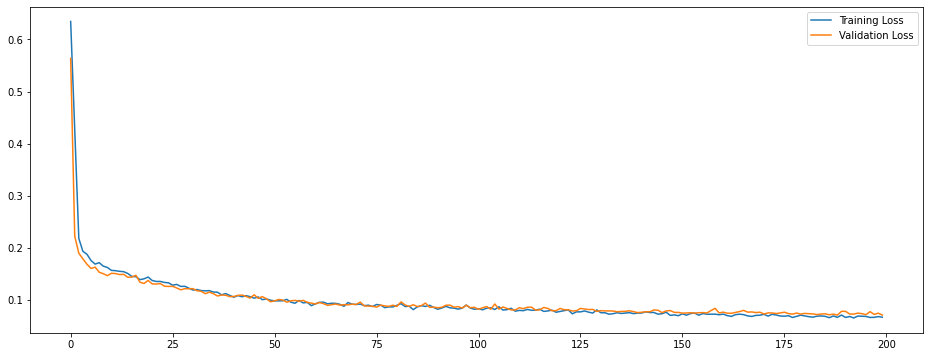

In [20]:
fig = plt.figure(figsize=(16,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
leg = plt.legend()



In [23]:
#Save Configuration
import json
global_config={**config,**config_traj,**config_preproc,**config_model}
for key in global_config.keys():
    global_config[key]=str(global_config[key])
filename = os.path.join(exp_dir,'config.json')
with open(filename, 'w') as f:
    f.write(json.dumps(global_config))


In [25]:
#Evaluate On Test Set
checkpoint_filepath=os.path.join(exp_dir,'ckpt/saved_model')
model.load_weights(checkpoint_filepath)
result = model.evaluate(dataset_withtransforms[2])
results_dict=dict(zip(model.metrics_names, result))
filename = os.path.join(exp_dir,'results.json')
with open(filename, 'w') as f:
    f.write(json.dumps(results_dict))

2023-05-31 14:07:06.165127: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model: FAILED_PRECONDITION: Training_folder/Test_FastDVDnet_20230531_103158/ckpt/saved_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


97/97 [==============================] - 24s 224ms/step - loss: 0.0701 - psnr: 30.9771 - ssim: 0.9299


Text(0.5, 1.0, 'Six consecutive frames with change: Top Input, Mid GT, Bottom Recon')

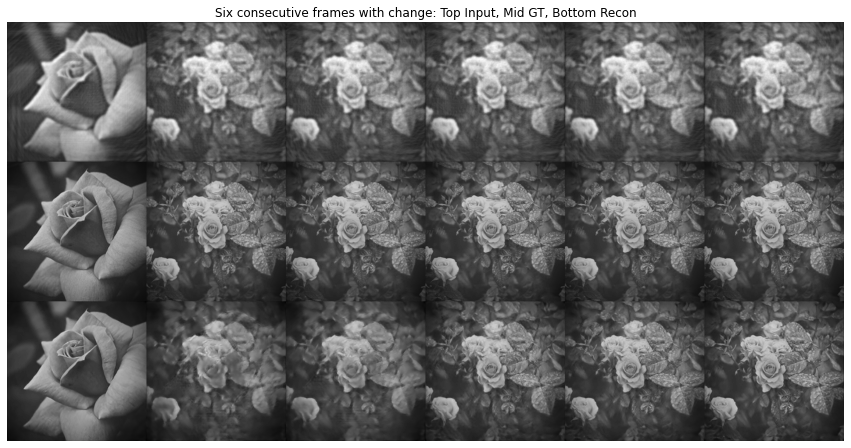

In [49]:
#Inference
#Preproc series 1
kspace=preproc_natural_image(test_files[0])
ds=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds)
for element in image:
  inputs_temp,gt_temp=preproc_function(element)
#Preproc series 2
kspace2=preproc_natural_image(test_files[2])
ds2=tf.data.Dataset.from_tensors(kspace2)
image2=traj_function(ds2)
for element in image2:
  inputs_temp2,gt_temp2=preproc_function(element)

#Run model on buffered 5 image in a series
inputs=np.concatenate((inputs_temp,inputs_temp2),axis=2)
gts=np.concatenate((gt_temp,gt_temp2),axis=2)
buffer=[]
output=[]
for pp in range(inputs.shape[-1]):
  buffer.append(inputs[:,:,pp])
  if pp>3:
    model_input=np.expand_dims(np.stack(buffer,axis=-1),axis=0)
    output.append(model(model_input))
    buffer=buffer[1:]

output=np.concatenate(output,axis=-1)
plot_image=np.concatenate((inputs[:,:,4:],gts[:,:,4:],output[0,...]),axis=0)

plt.figure(figsize=(15,12))
start_frame=7
plt.imshow(np.abs(np.concatenate((plot_image[:,:,start_frame],plot_image[:,:,start_frame+1],plot_image[:,:,start_frame+2],plot_image[:,:,start_frame+3],plot_image[:,:,start_frame+4],plot_image[:,:,start_frame+5]),axis=1)),cmap='gray')
plt.axis('off')
plt.title('Six consecutive frames with change: Top Input, Mid GT, Bottom Recon')